## Dataset

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train, valid, test = random_split(mnist, lengths=[.75, .1, .15])

train_loader = DataLoader(train, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

len(train), len(valid), len(test)

(45000, 6000, 9000)

## Model

In [75]:
# pytorch
import torch
from torch import tensor
import torch.nn as nn

# lightning
import pytorch_lightning as L

# other
import os
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.layer(x)
        return x


class Decoder(nn.Module):
    def __init__(self, embedding_dim: int, output_dim: int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(embedding_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.layer(x)
        return x


class Autoencoder(L.LightningModule):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()

        self.loss_fn = nn.MSELoss()

        self.encoder = Encoder(input_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(lr=0.001, params=self.parameters())


In [ ]:
log_save_dir = 'autoencoder_logs'

input_dim = 784
embedding_dim = 50

model = Autoencoder(input_dim, embedding_dim)

trainer = L.Trainer(
    logger=L.loggers.CSVLogger(save_dir=log_save_dir),
    max_epochs=5
)

trainer.fit(
    model, 
    train_loader, 
    valid_loader,
)

logs_df = get_latest_logs_as_df(log_save_dir)

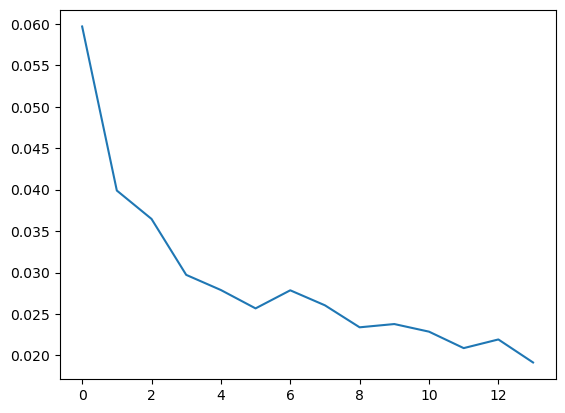

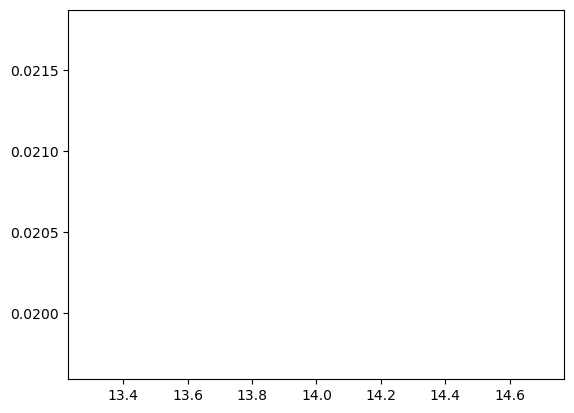

In [76]:
# logs_df

logs_df.train_loss.plot()
plt.show()
logs_df.val_loss.plot()
plt.show()

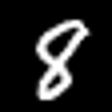

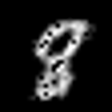

In [83]:
# visual test

test_ex = test[0][0]
display_tensor_as_image(test_ex)
display_tensor_as_image(model(test_ex))

## Visualization utils

In [79]:
from pathlib import Path

def get_latest_logs_as_df(log_save_dir) -> pd.DataFrame:
    log_versions_dir = f'{log_save_dir}/lightning_logs'
    latest_log_dir = os.listdir(log_dir)[-1]
    latest_csv = f'{log_versions_dir}/{latest_log_dir}/metrics.csv'

    return pd.read_csv(latest_csv)


def display_tensor_as_image(tensor):
    to_img = transforms.ToPILImage()
    tensor = tensor.view(28, 28)
    img: Image.Image = to_img(tensor)
    img = img.resize((28*4, 28*4))
    display(img)